<a href="https://colab.research.google.com/github/piltom/materia_machinelearning/blob/main/TrafficSignalRecon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing Traffic Signs
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise. 

In [2]:
dataroot = "dataroot/"

In [3]:
# Download and unzip

!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

--2020-11-02 14:33:41--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip’

data_1.zip          100%[===================>]  30.59M   104MB/s    in 0.3s    

2020-11-02 14:33:43 (104 MB/s) - ‘dataroot/data_1.zip’ saved [32074743/32074743]

--2020-11-02 14:33:43--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|

In [4]:
# Unzip
import zipfile
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

In [5]:
# Load sign names
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
signnames

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

In [6]:
# Load images
import pickle
signimages = pickle.load( open( dataroot+"train.p", "rb" ) )
signimages_test = pickle.load( open( dataroot+"test.p", "rb" ) )

Ejemplo de muestra:

The image shows a Turn left ahead sign


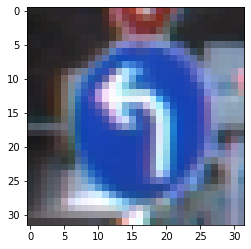

In [7]:
# Preview image
import matplotlib.pyplot as plt
import numpy as np

inx = 20123
plt.imshow(signimages['features'][inx])
print("The image shows a {} sign".format(signnames[signimages['labels'][inx]]))

# Resolución inicial
Se va a utilizar el histograma de gradientes orientados (HOG en ingles), que cuenta las ocurrencias de la orientación del gradiente en porciones de la imagen. Aparte de esto, se agregan 3 features más, que se corresponen con el promedio de valor de color de cada canal (normalizado).

Importo librerías (algunas no necesarias, hay que sacarlas)

In [8]:
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, hog, plot_matches)
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask

Genero un dataframe con las características del HOG y con el promedio de cada canal de color normalizado.

In [9]:
def gen_dataframe(imgs):
    hog_data = []
    for inx in range(len(imgs['features'])):
        image=imgs['features'][inx]
        descs = hog(image, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2), multichannel=True)
        tag_color_m = np.array([imgs['labels'][inx],np.mean(image[:,:,0])/255, np.mean(image[:,:,1])/255, np.mean(image[:,:,2]/255)])
        #tag_color_m = np.array([imgs['labels'][inx]])
        hog_data.append(np.concatenate((tag_color_m,descs)))
    ret_df=pd.DataFrame(hog_data)
    return ret_df.rename(columns={0: "target", 1: "r", 2: "g", 3: "b"})
    #return ret_df.rename(columns={0: "target"})

train_df=gen_dataframe(signimages)
test_df=gen_dataframe(signimages_test)
train_df

,target,r,g,b,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291
0,41.0,0.186428,0.167900,0.161929,0.122269,0.019866,0.010605,0.000000,0.029911,0.059485,0.152253,0.075938,0.279471,0.053520,0.072944,0.300001,0.342831,0.342831,0.297354,0.109977,0.188554,0.052986,0.022213,0.000000,0.027038,0.027715,0.043773,0.018286,0.246472,0.342831,0.342831,0.311936,0.054372,0.016951,0.018076,0.000000,0.176396,0.033781,0.046040,0.189354,...,0.078869,0.006811,0.275794,0.275794,0.133916,0.014159,0.031110,0.046258,0.108186,0.332383,0.332383,0.332383,0.169596,0.094858,0.062762,0.064957,0.332383,0.332383,0.003510,0.022371,0.038740,0.000000,0.030056,0.292958,0.096387,0.008324,0.332383,0.332383,0.163661,0.017304,0.038020,0.056533,0.032465,0.079044,0.172229,0.000000,0.031023,0.021123,0.028482,0.003924
1,41.0,0.179201,0.162626,0.154607,0.088510,0.008246,0.009985,0.000000,0.034971,0.078271,0.131602,0.034679,0.191772,0.043600,0.314599,0.199118,0.317791,0.317791,0.315107,0.000000,0.317791,0.030836,0.018677,0.000000,0.024586,0.008246,0.039038,0.000000,0.274086,0.317791,0.317791,0.317791,0.050792,0.015006,0.033797,0.031986,0.129024,0.029334,0.211663,0.133967,...,0.060721,0.002543,0.079312,0.321827,0.020835,0.009188,0.020152,0.087215,0.080152,0.383838,0.383838,0.383838,0.205862,0.046790,0.010935,0.069806,0.383838,0.383838,0.111517,0.014994,0.034461,0.033738,0.041016,0.081293,0.076654,0.003211,0.100124,0.383838,0.026302,0.011599,0.025439,0.110100,0.039179,0.024442,0.025877,0.000000,0.056233,0.016054,0.031576,0.004541
2,41.0,0.182744,0.164848,0.156553,0.104081,0.006017,0.012902,0.000000,0.074588,0.035132,0.101713,0.069952,0.225041,0.000000,0.179356,0.324091,0.324091,0.324091,0.294453,0.010282,0.324091,0.055584,0.036306,0.000000,0.028069,0.000000,0.026027,0.009924,0.224864,0.324091,0.324091,0.324091,0.057043,0.023706,0.000000,0.041358,0.155940,0.000000,0.124283,0.259659,...,0.088798,0.016780,0.187229,0.296156,0.088082,0.019281,0.020310,0.025338,0.165736,0.361224,0.361224,0.361224,0.272242,0.011416,0.000000,0.043627,0.361224,0.361224,0.069288,0.000000,0.035541,0.013378,0.027847,0.106747,0.114671,0.021670,0.241783,0.361224,0.113746,0.024899,0.026228,0.032721,0.047329,0.019710,0.048973,0.014441,0.038463,0.006333,0.029011,0.008956
3,41.0,0.183862,0.166295,0.158211,0.085771,0.002652,0.014392,0.003750,0.035888,0.061345,0.129521,0.056817,0.201607,0.006915,0.306864,0.306864,0.306864,0.303104,0.306864,0.009779,0.306864,0.188515,0.031005,0.003750,0.027469,0.005304,0.019695,0.085234,0.172070,0.306864,0.306864,0.306864,0.069175,0.000000,0.022389,0.039110,0.146860,0.005037,0.226543,0.263143,...,0.076500,0.022075,0.119099,0.308115,0.121777,0.012308,0.005749,0.031405,0.090802,0.365229,0.370214,0.370214,0.308585,0.030989,0.000000,0.020587,0.370214,0.370214,0.099500,0.000000,0.022149,0.003095,0.003095,0.052704,0.093285,0.026918,0.145230,0.370214,0.148496,0.015008,0.007011,0.038295,0.038358,0.013112,0.052084,0.005708,0.054744,0.013078,0.022108,0.030327
4,41.0,0.182368,0.164932,0.155902,0.097855,0.006783,0.024157,0.008459,0.050118,0.085699,0.093045,0.072452,0.307683,0.013981,0.157378,0.327662,0.327662,0.327662,0.195712,0.025907,0.327662,0.158129,0.038987,0.008459,0.030376,0.005192,0.026893,0.028427,0.129054,0.327662,0.327662,0.327662,0.100014,0.000000,0.006568,0.006253,0.203060,0.009227,0.103864,0.263801,...,0.073085,0.014410,0.287788,0.287788,0.044519,0.004633,0.004633,0.009828,0.205087,0.358809,0.358809,0.269424,0.257588,0.027399,0.032859,0.165974,0.358809,0.320800,0.005901,0.000000,0.027818,0.005015,0.019990,0.138318,0.098120,0.019346,0.358809,0.358809,0.059769,0.006220,0.006220,0.013195,0.047742,0.020566,0.029763,0.004398,0.047291,0.026786,0.045791,0.011889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Separo en X e y, hago el fit e imprimo las métricas.

In [10]:
from sklearn import svm, metrics
classifier = svm.LinearSVC()
#train_df_s=train_df.sample(frac=0.20)
train_df_s=train_df
X_train=train_df_s.drop(['target'],axis=1)
y_train=train_df_s['target']

In [11]:
# Aprenda a clasificar el conjunto de entrenamiento
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(test_df.drop(['target'],axis=1))

print("Classification report for classifier {}\n{}\n".format(classifier, metrics.classification_report(test_df['target'], y_predicted)))

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
              precision    recall  f1-score   support

         0.0       0.54      0.42      0.47        60
         1.0       0.60      0.68      0.64       720
         2.0       0.67      0.70      0.69       750
         3.0       0.55      0.66      0.60       450
         4.0       0.87      0.88      0.88       660
         5.0       0.57      0.49      0.53       630
         6.0       0.89      0.73      0.81       150
         7.0       0.70      0.65      0.67       450
         8.0       0.65      0.65      0.65       450
         9.0       0.79      0.84      0.81       480
        10.0       0.88      0.94      0.91       660
        11.0       0.70      0.66      0.68       420
        12.0       0.98      0

Los que peor andan son aquellos que tienen pequeños detalles que difieren poco entre clases dentro del cartel. Por ejemplo, los carteles de velocidad máxima, que tienen números dentro que pueden ser parecidos.

Para mejorar esta clasificación hay muchas posibilidades. Una de ellas es agrupar los carteles similares en categorías "padre" y en un principio clasificar dentro de ellas. Luego, dependiendo de la naturaleza de las diferencias entre las subclases, se pueden extraer nuevas características del subconjunto dependiendo de de cual categoría "padre" se trate. 